Name: Kulboboev Shukhrat


Neptun Code : JDN3HW


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV

# Step 1: Load the Dataset and data analysis
public_data = pd.read_csv('public_data.csv')

In [10]:
public_data.info

<bound method DataFrame.info of        rowID  season  periodID  day_in_period  hour  minute  holyday  weekday  \
0          0       1        18              0     0       0    False        2   
1          1       1        18              0     0      15    False        2   
2          2       1        18              0     0      30    False        2   
3          3       1        18              0     0      45    False        2   
4          4       1        18              0     1       0    False        2   
...      ...     ...       ...            ...   ...     ...      ...      ...   
89755  93260      11       194              4    22      45    False        1   
89756  93261      11       194              4    23       0    False        1   
89757  93262      11       194              4    23      15    False        1   
89758  93263      11       194              4    23      30    False        1   
89759  93264      11       194              4    23      45    False        1

In [16]:
public_data.describe()

,rowID,season,periodID,day_in_period,hour,minute,weekday,ke,hupx,afrr_fel,afrr_le,mfrr_fel,mfrr_le,afrr,solar_becsult_dayahead,rendszerterheles_terv,target_flag,target_reg
count,89760.000000,89760.000000,89760.000000,89760.000000,89760.000000,89760.000000,89760.000000,71808.000000,71808.000000,71808.000000,71808.000000,71808.000000,71808.000000,71808.000000,89760.000000,89760.000000,71808.000000,71808.000000
mean,46909.416578,5.897326,96.529412,2.000000,11.500000,22.500000,3.004278,851.362651,295.273332,59.974674,-108.081189,1.226249,-1.792931,76.215899,629.272277,5752.499782,0.658381,-3.805170
std,26663.473071,3.047264,56.315251,1.414221,6.922225,16.770603,2.003746,116.940467,144.614449,111.800238,222.706543,13.201808,21.569346,465.306608,841.924425,895.642042,0.474256,249.907271
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2132.453650,-555.000000,0.000000,-2712.487600,0.000000,-758.055000,-2747.487440,0.000000,2857.908990,0.000000,-4012.381036
25%,24175.750000,3.000000,48.000000,1.000000,5.750000,11.250000,1.000000,797.511065,233.751200,0.000000,-113.753725,0.000000,0.000000,-222.511652,0.000000,5085.953814,0.000000,-101.776524
50%,46615.500000,6.000000,96.000000,2.000000,11.500000,22.500000,3.000000,811.904403,247.567000,2.202200,-42.161033,0.000000,0.000000,-80.311780,38.080260,5280.782670,1.000000,68.034948
75%,69963.250000,9.000000,145.000000,3.000000,17.250000,33.750000,5.000000,880.522912,278.498075,65.067600,-3.689775,0.000000,0.000000,284.422770,1324.875228,6415.845635,1.000000,124.526755
max,93264.000000,11.000000,194.000000,4.000000,23.000000,45.000000,6.000000,4354.471274,1162.281000,986.661000,0.000000,237.500000,0.000000,2381.311107,3150.724900,7745.020000,1.000000,2341.985660


In [19]:
public_data.isna().sum()

rowID                         0
season                        0
periodID                      0
day_in_period                 0
hour                          0
minute                        0
holyday                       0
weekday                       0
ke                        17952
hupx                      17952
afrr_fel                  17952
afrr_le                   17952
mfrr_fel                  17952
mfrr_le                   17952
afrr                      17952
solar_becsult_dayahead        0
rendszerterheles_terv         0
target_flag               17952
target_reg                17952
dtype: int64

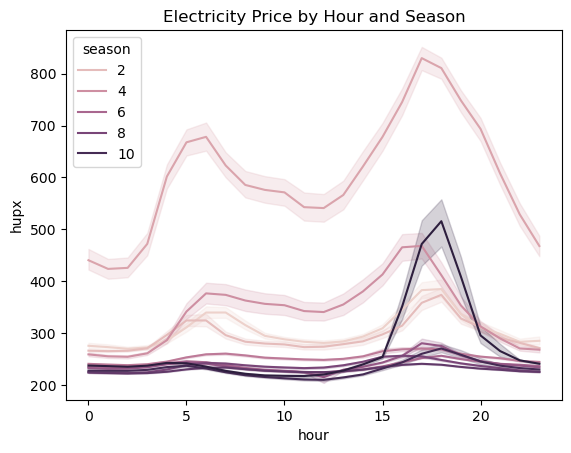

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
# Time-series trends
sns.lineplot(x='hour', y='hupx', data=public_data, hue='season')
plt.title("Electricity Price by Hour and Season")
plt.show()

<Axes: >

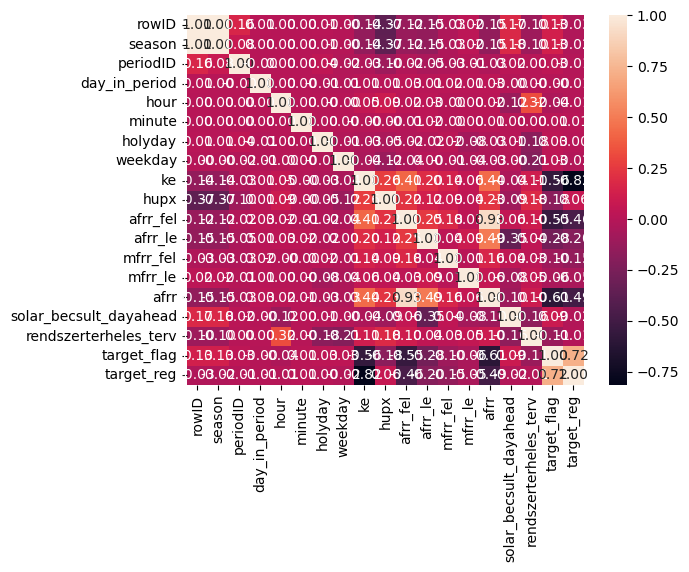

In [26]:
# Correlation matrix
correlation_matrix = public_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")

In [37]:

# Step 2: Preprocess the Data
def preprocess_data(data):
    # Filter rows for prediction (day_in_period == 4)
    prediction_data = data[data['day_in_period'] == 4]
    training_data = data[data['day_in_period'] != 4]

    # Fill missing values with mean
    training_data.fillna(training_data.mean(), inplace=True)
    prediction_data.fillna(prediction_data.mean(), inplace=True)

    return training_data, prediction_data

training_data, prediction_data = preprocess_data(public_data)

# Step 3: Feature Engineering
def feature_engineering(data):
    # Columns for feature engineering
    rolling_features = ['ke', 'hupx', 'afrr_fel', 'afrr_le', 'mfrr_fel', 'mfrr_le', 'afrr']

    # Add rolling mean and standard deviation
    for feature in rolling_features:
        data[f'{feature}_rolling_mean'] = data.groupby('periodID')[feature].transform(
            lambda x: x.rolling(window=4, min_periods=1).mean())
        data[f'{feature}_rolling_std'] = data.groupby('periodID')[feature].transform(
            lambda x: x.rolling(window=4, min_periods=1).std())

    # Add lag features
    for feature in rolling_features:
        data[f'{feature}_lag_1'] = data.groupby('periodID')[feature].shift(1)

    # Add interaction feature: normalized load
    data['normalized_load'] = data['rendszerterheles_terv'] / (data['afrr_fel'] + 1)

    # Add cyclical features for time
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['minute_sin'] = np.sin(2 * np.pi * data['minute'] / 60)
    data['minute_cos'] = np.cos(2 * np.pi * data['minute'] / 60)

    return data

training_data = feature_engineering(training_data)
prediction_data = feature_engineering(prediction_data)

# Step 4: Define Features and Target
features_to_drop = ['rowID', 'season', 'periodID', 'day_in_period', 'hour', 'minute', 'target_reg', 'target_flag']
X_train = training_data.drop(columns=features_to_drop)
y_train = training_data['target_flag']

# Step 5: Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Step 6: Handle Missing Values Before SMOTE
imputer = SimpleImputer(strategy='mean')  # You can also try 'median' or 'most_frequent'
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)

# Step 7: Handle Imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled_imputed, y_train)

# Step 7: Train-Test Split for Validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# Step 8: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2
)
grid_search.fit(X_train_split, y_train_split)

best_model = grid_search.best_estimator_

# Step 9: Evaluate on Validation Set
val_predictions = best_model.predict_proba(X_val_split)[:, 1]
auc_score = roc_auc_score(y_val_split, val_predictions)
print(f"Validation AUC Score after Tuning: {auc_score:.4f}")

# Step 10: Calibrate Probabilities
calibrated_model = CalibratedClassifierCV(best_model, method='isotonic', cv='prefit')
calibrated_model.fit(X_val_split, y_val_split)

# Step 11: Prepare Test Predictions
X_test = prediction_data.drop(columns=features_to_drop)
X_test_scaled = scaler.transform(X_test)
test_predictions = calibrated_model.predict_proba(X_test_scaled)[:, 1]

# Create Submission File
submission = prediction_data[['rowID']].copy()
submission['Prediction'] = test_predictions
submission.to_csv('submission_12.csv', index=False)
print("Submission file created: /mnt/data/submission.csv")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END max_depth=7, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  17.5s
[CV] END max_depth=7, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  17.2s
[CV] END max_depth=7, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  17.2s
[CV] END max_depth=7, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  51.7s
[CV] END max_depth=7, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  52.2s
[CV] END max_depth=7, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  51.6s
[CV] END max_depth=7, max_features=sqrt, min_samples_split=2, n_estimators=500; total time= 1.4min
[CV] END max_depth=7, max_features=sqrt, min_samples_split=2, n_estimators=500; total time= 1.5min
[CV] END max_depth=7, max_features=sqrt, min_samples_split=2, n_estimators=500; total time= 1.4min
[CV] END max_depth=7, max_features=sqrt, min_sa